# Isolating members based on extreme surface heat flux anomalies

Here, we isolate members that had extreme surface heat flux anomalies in 1. Irminger Sea 2. Labrador Sea

In [1]:
# Load libraries

import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
#import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize
from dask.distributed import Client, performance_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")


ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_TS = []

var_list2 = ['hfds', 'tos', 'sos']

for var in var_list2:
    
    ds1 = []
    
    for i in range(0,10):
    
        d = xr.open_dataset(ppdir + "Area_mean_timeseries/Anomaly_" + var + "_r" + str(i+1) + ".nc")
        
        ds1.append(d)
    
    ds1 = xr.concat(ds1, dim='r')
    
    ds_TS.append(ds1)

ds_TS = xr.concat(ds_TS, dim='var')

print(ds_NAO, ds_TS)

<xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_south     (start_year, r, time) float64 ...
    P_north     (start_year, r, time) float64 ...
    time_val    (start_year, time) object ... <xarray.Dataset>
Dimensions:            (var: 3, r: 10, start_year: 57, time: 125)
Dimensions without coordinates: var, r, start_year, time
Data variables:
    Labrador_Sea       (var, r, start_year, time) float32 -23.22 ... -0.225
    Irminger_Sea       (var, r, start_year, time) float32 -26.75 ... -0.1122
    Iceland_Basin      (var, r, start_year, time) float32 13.48 ... -0.09676
    North_East_Region  (var, r, start_year, time) float32 7.781 ... -0.2074
    South_West_Region  (var, r, start_year, time) float32 4.255 ... -0.2022
    South_East_Region  (var, r, start_year, time) 

In [5]:
NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

ds_TS = ds_TS.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg
HF_Irm = ds_TS['Irminger_Sea'].isel(var=0, time=slice(1,len(NAO_season.time)-1))
HF_Lab = ds_TS['Labrador_Sea'].isel(var=0, time=slice(1,len(NAO_season.time)-1))

%time NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()
%time HF_Irm = HF_Irm.resample(time='QS-DEC').mean('time').compute()
%time HF_Lab = HF_Lab.resample(time='QS-DEC').mean('time').compute()

CPU times: user 43.9 ms, sys: 10.6 ms, total: 54.5 ms
Wall time: 60.2 ms
CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 17.3 ms
CPU times: user 15.8 ms, sys: 49 µs, total: 15.8 ms
Wall time: 15.6 ms


Text(0.5, 1.0, 'Labrador Sea')

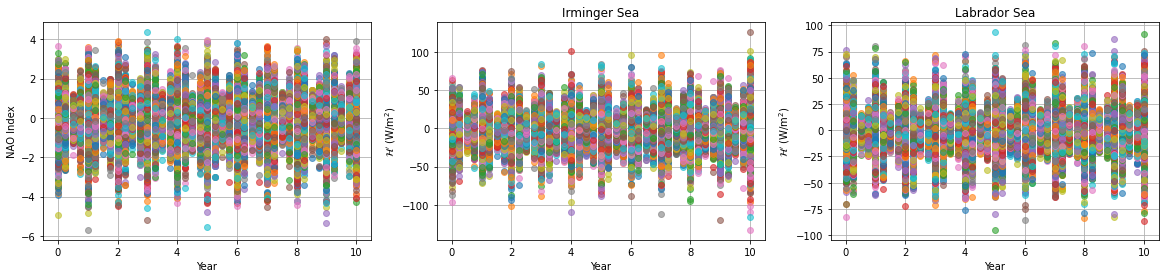

In [52]:
fig = plt.figure(figsize=[20,4])

plt.subplot(1,3,1)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(np.arange(0,len(NAO_season.time))/4, NAO_season.isel(start_year=year, r=r),'o', alpha=0.6)
        
plt.grid('on')
plt.ylabel('NAO Index')
plt.xlabel('Year')

plt.subplot(1,3,2)
for year in range(0,len(ds_NAO['start_year'])):
    for r in range(0,10):
        plt.plot(np.arange(0,len(NAO_season.time))/4, HF_Irm.isel(start_year=year, r=r),'o', alpha=0.6)
        
plt.grid('on')
plt.ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)')
plt.xlabel('Year')
plt.title('Irminger Sea')

plt.subplot(1,3,3)
for year in range(0,len(ds_NAO['start_year'])):
    for r in range(0,10):
        plt.plot(np.arange(0,len(NAO_season.time))/4, HF_Lab.isel(start_year=year, r=r),'o', alpha=0.6)
        
plt.grid('on')
plt.ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)')
plt.xlabel('Year')
plt.title('Labrador Sea')

## Read Overturning data

In [10]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl', 'sltovgyre_atlantic', 'sltovovrt_atlantic',
           'hfovgyre_atlantic', 'hfovovrt_atlantic']

ds = xr.open_dataset(ppdir+"Overturning_z.nc", decode_times=False, chunks={'y':10})
ds = ds.get(var_list)
ds = xr.decode_cf(ds)

ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []

for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir_drift + "diaptr/" + "Drift_diaptr_Lead_Year_" + 
                        str(lead_year + 1) + ".nc", decode_times= False)
    d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time_counter'])), 1))
    
    ds_drift.append(d)
    
ds_drift = xr.concat(ds_drift, dim='time_counter')

ds_drift = ds_drift.get(var_list)

ds_drift = ds_drift.chunk({'y':10})

ds = ds.drop('time_counter') 

# --- Only for testing (actually drift is removed separately for each ensemble) ----------
ds_drift = ds_drift.mean('r') 
# -------------------------------

ds_drift = ds_drift.drop(['time_counter','start_year'])

ds_anom = ds - ds_drift

psi_anom = ds.zomsfatl.mean(['x']).max(dim='depthw') - ds_drift.zomsfatl.mean(['x']).max(dim='depthw')

ds_anom['psi_anom'] = psi_anom #anomaly in psi max 

print(ds_anom)

<xarray.Dataset>
Dimensions:             (depthw: 75, y: 451, x: 1, start_year: 57, r: 10,
                         time_counter: 125)
Coordinates:
  * depthw              (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat             (y, x) float32 3.997 4.246 4.495 ... 79.85 79.92 79.99
    nav_lon             (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * start_year          (start_year) int64 1960 1961 1962 ... 2014 2015 2016
Dimensions without coordinates: y, x, r, time_counter
Data variables:
    hfbasin_atlantic    (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 10, 125, 10, 1), meta=np.ndarray>
    sltbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 10, 125, 10, 1), meta=np.ndarray>
    zomsfatl            (start_year, r, time_counter, depthw, y, x) float32 dask.array<chunksize=(57, 10, 125, 75, 10, 1), meta=np.ndarray>
    sltovgyre_atlantic  (start_year, r, time_counter, y, x) float32 dask

In [11]:
psi_max= ds_anom['psi_anom'].rename({'time_counter':'time'})
psi_max = psi_max.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)
psi_max = psi_max.sel(y= [30., 35., 40., 45., 50., 55., 60.], method="nearest")

HT = ds_anom['hfbasin_atlantic'].mean('x')
HT = HT.rename({'time_counter':'time'})
HT = HT.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)
HT = HT.sel(y= [30., 35., 40., 45., 50., 55., 60.], method="nearest")

HT_gyre = ds_anom['hfovgyre_atlantic'].mean('x')
HT_gyre = HT_gyre.rename({'time_counter':'time'})
HT_gyre = HT_gyre.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)
HT_gyre = HT_gyre.sel(y= [30., 35., 40., 45., 50., 55., 60.], method="nearest")

HT_psi = ds_anom['hfovovrt_atlantic'].mean('x')
HT_psi = HT_psi.rename({'time_counter':'time'})
HT_psi = HT_psi.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)
HT_psi = HT_psi.sel(y= [30., 35., 40., 45., 50., 55., 60.], method="nearest")

ds_max = xr.Dataset()

with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time ds_max['psi_max'] = psi_max.compute()
    %time ds_max['HT'] = HT.compute()
    %time ds_max['HT_gyre'] = HT_gyre.compute()
    %time ds_max['HT_psi'] = HT_psi.compute()

CPU times: user 7.91 s, sys: 20.7 s, total: 28.6 s
Wall time: 29.8 s
CPU times: user 150 ms, sys: 329 ms, total: 479 ms
Wall time: 483 ms
CPU times: user 160 ms, sys: 265 ms, total: 424 ms
Wall time: 453 ms
CPU times: user 171 ms, sys: 331 ms, total: 502 ms
Wall time: 508 ms


## 1. Irminger Sea case

Isolate members based on Irminger Sea positive and negatuve surface heat fluxes

In [17]:
HF_cut = 50.

count_HFp = 0
count_HFn = 0

for ind in range(4,13,4):
    
    c_HFp = (xr.where(HF_Irm.isel(time=ind) >= HF_cut, 1, 0)).sum().values
    c_HFn = (xr.where(HF_Irm.isel(time=ind) <= -HF_cut, 1, 0)).sum().values
    
    count_HFp =  count_HFp + c_HFp
    count_HFn =  count_HFn + c_HFn

print('NAO positive members = ', count_HFp)
print('NAO negative members = ', count_HFn)

NAO positive members =  58
NAO negative members =  83


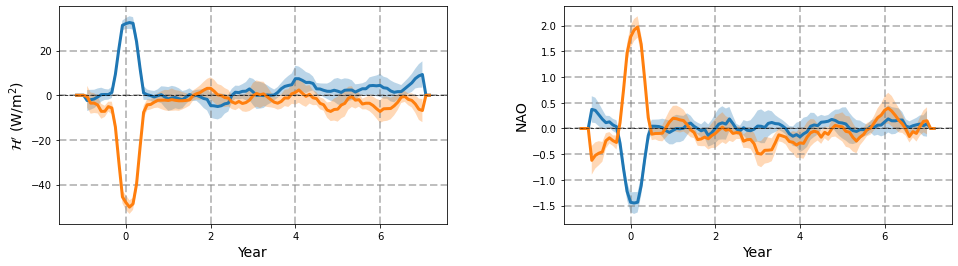

In [29]:
case_list = ['HFp', 'HFn']
HF_cut = 50.

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,4])

ax1 = fig.add_subplot(grid1[0, 0])
ax2 = fig.add_subplot(grid1[0, 1])

for case in case_list:
    
    tmp_NAO = []
    tmp_HF = []
    
    if (case == 'HFp'):
        
        N = count_HFp
        std_err = (1.96/np.sqrt(np.ceil(N)))
            
        for ind in range(4,13,4):

            tmp1 = ds_NAO['NAO'].where(HF_Irm.isel(time=ind).drop('time') >= HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))
            tmp_NAO.append(tmp1)
            
            tmp1 = ds_TS['Irminger_Sea'].isel(var=0).where(HF_Irm.isel(time=ind).drop('time') >= HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')
            tmp_HF.append(tmp1)

        tmp_NAO = xr.concat(tmp_NAO,dim='case')
        tmp_NAO = tmp_NAO.rolling(time=6, center=True).mean('time')
        tmp_NAO_std = tmp_NAO.std(['start_year','r', 'case'])
        tmp_NAO = tmp_NAO.sum(['start_year','r','case']) / N
        
        tmp_HF = xr.concat(tmp_HF,dim='case')
        tmp_HF = tmp_HF.rolling(time=6, center=True).mean('time')
        tmp_HF_std = tmp_HF.std(['start_year','r', 'case'])
        tmp_HF = tmp_HF.sum(['start_year','r','case']) / N
        

    elif(case == 'HFn'):
        
        N = count_HFp
        std_err = (1.96/np.sqrt(np.ceil(N)))
            
        for ind in range(4,13,4):

            tmp1 = ds_NAO['NAO'].where(HF_Irm.isel(time=ind).drop('time') <= - HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))
            tmp_NAO.append(tmp1)
            
            tmp1 = ds_TS['Irminger_Sea'].isel(var=0).where(HF_Irm.isel(time=ind).drop('time') <= -HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')
            tmp_HF.append(tmp1)

        tmp_NAO = xr.concat(tmp_NAO,dim='case')
        tmp_NAO = tmp_NAO.rolling(time=6, center=True).mean('time')
        tmp_NAO_std = tmp_NAO.std(['start_year','r', 'case'])
        tmp_NAO = tmp_NAO.sum(['start_year','r','case']) / N
        
        tmp_HF = xr.concat(tmp_HF,dim='case')
        tmp_HF = tmp_HF.rolling(time=6, center=True).mean('time')
        tmp_HF_std = tmp_HF.std(['start_year','r', 'case'])
        tmp_HF = tmp_HF.sum(['start_year','r','case']) / N
        
    ax1.plot(np.arange(0+10,len(tmp_HF.time)+10) / 12 - 2, tmp_HF, lw=3.)
    ax1.fill_between(np.arange(0+10,len(tmp_HF.time)+10) / 12 - 2, (tmp_HF.values - std_err*tmp_HF_std.values), 
                    (tmp_HF.values + std_err*tmp_HF_std.values), alpha=0.3)
    ax1.axhline(y=0, ls='-.', lw=0.5, color='k')
    ax1.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    ax1.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)', fontsize=14)
    ax1.set_xlabel('Year', fontsize=14)
    
    ax2.plot(np.arange(0+10,len(tmp_NAO.time)+10) / 12 - 2, tmp_NAO, lw=3.)
    ax2.fill_between(np.arange(0+10,len(tmp_HF.time)+10) / 12 - 2, (tmp_NAO.values - std_err*tmp_NAO_std.values), 
                    (tmp_NAO.values + std_err*tmp_NAO_std.values), alpha=0.3)
    ax2.axhline(y=0, ls='-.', lw=0.5, color='k')
    ax2.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    ax2.set_ylabel(r'NAO', fontsize=14)
    ax2.set_xlabel('Year', fontsize=14)

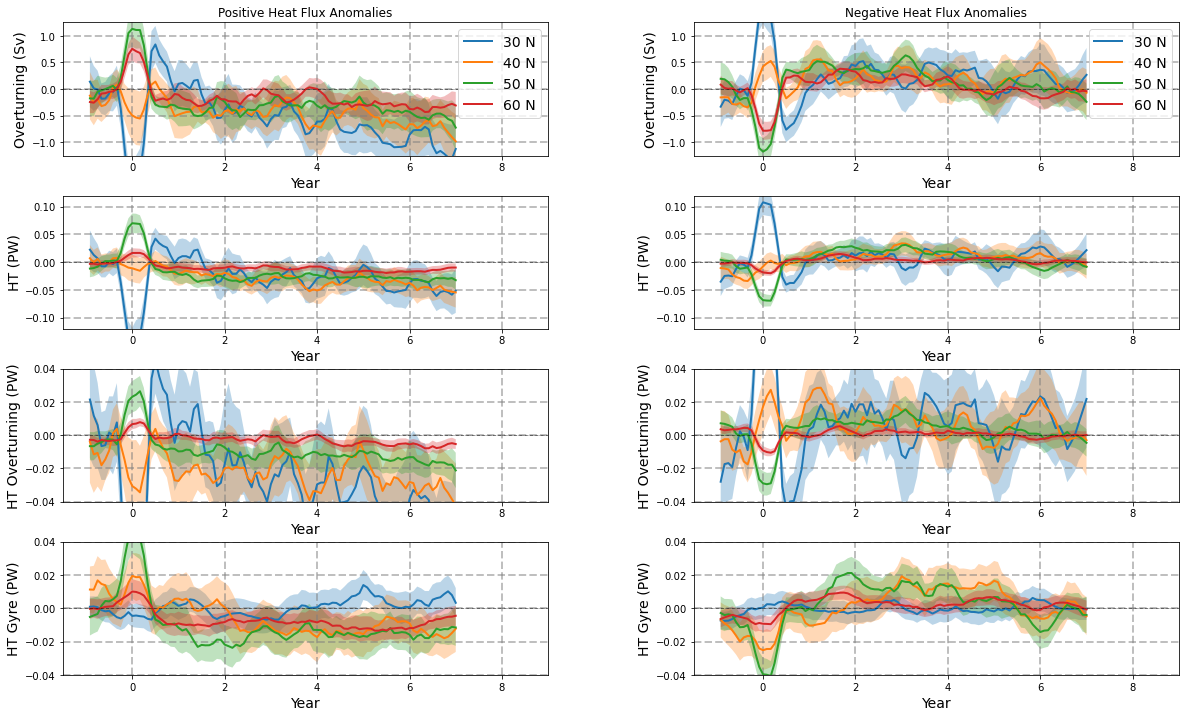

In [32]:
varss = ['psi_max', 'HT', 'HT_psi', 'HT_gyre']
var_name = ['Overturning (Sv)', 'HT (PW)', 'HT Overturning (PW)', 'HT Gyre (PW)']
case_list = ['HFp', 'HFn']
HF_cut = 50.

grid1 = plt.GridSpec(4, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[20,12])

for case in case_list:
    
    var_ind = 0

    for var in varss:

        tmp = []

        if (case == 'HFp'):

            j=0
            N = count_NAOp
            std_err = (1.96/np.sqrt(np.ceil(N)))

            for ind in range(4,13,4):

                tmp1 = ds_max[var].where(HF_Irm.isel(time=ind).drop('time') >= HF_cut)
                tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')

                tmp.append(tmp1)

            tmp = xr.concat(tmp,dim='case')
            tmp = tmp.rolling(time=6, center=True).mean('time')

            ax = fig.add_subplot(grid1[var_ind, 0])


        elif(case == 'HFn'):

            j=1
            N = count_NAOn
            std_err = (1.96/np.sqrt(np.ceil(N)))

            for ind in range(4,13,4):

                tmp1 = ds_max[var].where(HF_Irm.isel(time=ind).drop('time') <= -HF_cut)
                tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')

                tmp.append(tmp1)

            tmp = xr.concat(tmp,dim='case')
            tmp = tmp.rolling(time=6, center=True).mean('time')

            ax = fig.add_subplot(grid1[var_ind, 1])


        for y in range(0,len(tmp.y), 2):

            tmp1_std = tmp.sel(y= tmp['y'].values[y], method="nearest").std(['start_year','r', 'case'])
            tmp1 = tmp.mean(['start_year','r','case']).sel(y= tmp['y'].values[y], method="nearest")

            ax.plot(np.arange(0+10,len(tmp1.time)+10) / 12 - 2, tmp1, lw=2., 
                    label=str(math.floor(tmp1['y'].values)) + ' N')
            ax.fill_between(np.arange(0+10,len(tmp1.time)+10) / 12 - 2, (tmp1.values - std_err*tmp1_std.values), 
                        (tmp1.values + std_err*tmp1_std.values), alpha=0.3)

        ax.axhline(y=0, ls='-.', lw=0.5, color='k')
        ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
        ax.set_ylabel(var_name[var_ind], fontsize=14)
        ax.set_xlabel('Year', fontsize=14)
        
        if(var=='psi_max' and case=='HFp'):
            ax.set_title("Positive Heat Flux Anomalies")
            ax.set_ylim([-1.25, 1.25])
            ax.legend(fontsize=14)
            
        elif(var=='psi_max' and case=='HFn'):
            ax.set_title("Negative Heat Flux Anomalies")
            ax.set_ylim([-1.25, 1.25])
            ax.legend(fontsize=14)
        
        if(var=='HT'):
            ax.set_ylim([-.12, .12])
        elif(var=='HT_gyre' or var=='HT_psi'):
            ax.set_ylim([-.04, .04])
        ax.set_xlim([-1.5, 9])
    
        var_ind = var_ind + 1
    

## 2. Labrador Sea

In [33]:
HF_cut = 50.

count_HFp = 0
count_HFn = 0

for ind in range(4,13,4):
    
    c_HFp = (xr.where(HF_Lab.isel(time=ind) >= HF_cut, 1, 0)).sum().values
    c_HFn = (xr.where(HF_Lab.isel(time=ind) <= -HF_cut, 1, 0)).sum().values
    
    count_HFp =  count_HFp + c_HFp
    count_HFn =  count_HFn + c_HFn

print('NAO positive members = ', count_HFp)
print('NAO negative members = ', count_HFn)

NAO positive members =  39
NAO negative members =  47


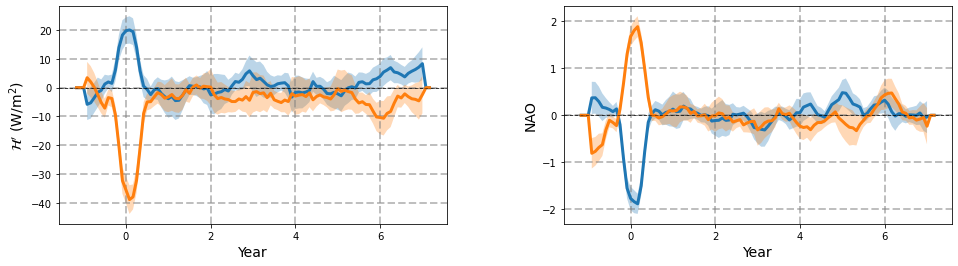

In [34]:
case_list = ['HFp', 'HFn']
HF_cut = 50.

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,4])

ax1 = fig.add_subplot(grid1[0, 0])
ax2 = fig.add_subplot(grid1[0, 1])

for case in case_list:
    
    tmp_NAO = []
    tmp_HF = []
    
    if (case == 'HFp'):
        
        N = count_HFp
        std_err = (1.96/np.sqrt(np.ceil(N)))
            
        for ind in range(4,13,4):

            tmp1 = ds_NAO['NAO'].where(HF_Lab.isel(time=ind).drop('time') >= HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))
            tmp_NAO.append(tmp1)
            
            tmp1 = ds_TS['Irminger_Sea'].isel(var=0).where(HF_Lab.isel(time=ind).drop('time') >= HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')
            tmp_HF.append(tmp1)

        tmp_NAO = xr.concat(tmp_NAO,dim='case')
        tmp_NAO = tmp_NAO.rolling(time=6, center=True).mean('time')
        tmp_NAO_std = tmp_NAO.std(['start_year','r', 'case'])
        tmp_NAO = tmp_NAO.sum(['start_year','r','case']) / N
        
        tmp_HF = xr.concat(tmp_HF,dim='case')
        tmp_HF = tmp_HF.rolling(time=6, center=True).mean('time')
        tmp_HF_std = tmp_HF.std(['start_year','r', 'case'])
        tmp_HF = tmp_HF.sum(['start_year','r','case']) / N
        

    elif(case == 'HFn'):
        
        N = count_HFp
        std_err = (1.96/np.sqrt(np.ceil(N)))
            
        for ind in range(4,13,4):

            tmp1 = ds_NAO['NAO'].where(HF_Lab.isel(time=ind).drop('time') <= - HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))
            tmp_NAO.append(tmp1)
            
            tmp1 = ds_TS['Irminger_Sea'].isel(var=0).where(HF_Lab.isel(time=ind).drop('time') <= -HF_cut)
            tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')
            tmp_HF.append(tmp1)

        tmp_NAO = xr.concat(tmp_NAO,dim='case')
        tmp_NAO = tmp_NAO.rolling(time=6, center=True).mean('time')
        tmp_NAO_std = tmp_NAO.std(['start_year','r', 'case'])
        tmp_NAO = tmp_NAO.sum(['start_year','r','case']) / N
        
        tmp_HF = xr.concat(tmp_HF,dim='case')
        tmp_HF = tmp_HF.rolling(time=6, center=True).mean('time')
        tmp_HF_std = tmp_HF.std(['start_year','r', 'case'])
        tmp_HF = tmp_HF.sum(['start_year','r','case']) / N
        
    ax1.plot(np.arange(0+10,len(tmp_HF.time)+10) / 12 - 2, tmp_HF, lw=3.)
    ax1.fill_between(np.arange(0+10,len(tmp_HF.time)+10) / 12 - 2, (tmp_HF.values - std_err*tmp_HF_std.values), 
                    (tmp_HF.values + std_err*tmp_HF_std.values), alpha=0.3)
    ax1.axhline(y=0, ls='-.', lw=0.5, color='k')
    ax1.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    ax1.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)', fontsize=14)
    ax1.set_xlabel('Year', fontsize=14)
    
    ax2.plot(np.arange(0+10,len(tmp_NAO.time)+10) / 12 - 2, tmp_NAO, lw=3.)
    ax2.fill_between(np.arange(0+10,len(tmp_HF.time)+10) / 12 - 2, (tmp_NAO.values - std_err*tmp_NAO_std.values), 
                    (tmp_NAO.values + std_err*tmp_NAO_std.values), alpha=0.3)
    ax2.axhline(y=0, ls='-.', lw=0.5, color='k')
    ax2.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    ax2.set_ylabel(r'NAO', fontsize=14)
    ax2.set_xlabel('Year', fontsize=14)

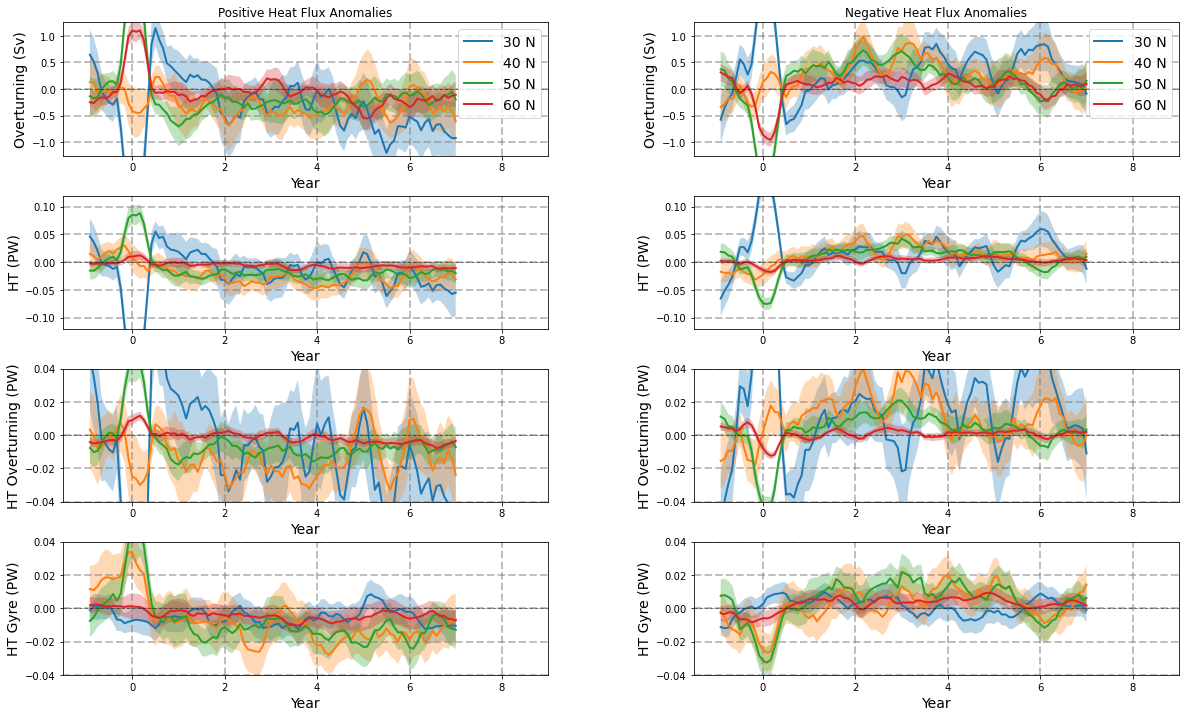

In [35]:
varss = ['psi_max', 'HT', 'HT_psi', 'HT_gyre']
var_name = ['Overturning (Sv)', 'HT (PW)', 'HT Overturning (PW)', 'HT Gyre (PW)']
case_list = ['HFp', 'HFn']
HF_cut = 50.

grid1 = plt.GridSpec(4, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[20,12])

for case in case_list:
    
    var_ind = 0

    for var in varss:

        tmp = []

        if (case == 'HFp'):

            j=0
            N = count_NAOp
            std_err = (1.96/np.sqrt(np.ceil(N)))

            for ind in range(4,13,4):

                tmp1 = ds_max[var].where(HF_Lab.isel(time=ind).drop('time') >= HF_cut)
                tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')

                tmp.append(tmp1)

            tmp = xr.concat(tmp,dim='case')
            tmp = tmp.rolling(time=6, center=True).mean('time')

            ax = fig.add_subplot(grid1[var_ind, 0])


        elif(case == 'HFn'):

            j=1
            N = count_NAOn
            std_err = (1.96/np.sqrt(np.ceil(N)))

            for ind in range(4,13,4):

                tmp1 = ds_max[var].where(HF_Lab.isel(time=ind).drop('time') <= -HF_cut)
                tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).drop('time')

                tmp.append(tmp1)

            tmp = xr.concat(tmp,dim='case')
            tmp = tmp.rolling(time=6, center=True).mean('time')

            ax = fig.add_subplot(grid1[var_ind, 1])


        for y in range(0,len(tmp.y), 2):

            tmp1_std = tmp.sel(y= tmp['y'].values[y], method="nearest").std(['start_year','r', 'case'])
            tmp1 = tmp.mean(['start_year','r','case']).sel(y= tmp['y'].values[y], method="nearest")

            ax.plot(np.arange(0+10,len(tmp1.time)+10) / 12 - 2, tmp1, lw=2., 
                    label=str(math.floor(tmp1['y'].values)) + ' N')
            ax.fill_between(np.arange(0+10,len(tmp1.time)+10) / 12 - 2, (tmp1.values - std_err*tmp1_std.values), 
                        (tmp1.values + std_err*tmp1_std.values), alpha=0.3)

        ax.axhline(y=0, ls='-.', lw=0.5, color='k')
        ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
        ax.set_ylabel(var_name[var_ind], fontsize=14)
        ax.set_xlabel('Year', fontsize=14)
        
        if(var=='psi_max' and case=='HFp'):
            ax.set_title("Positive Heat Flux Anomalies")
            ax.set_ylim([-1.25, 1.25])
            ax.legend(fontsize=14)
            
        elif(var=='psi_max' and case=='HFn'):
            ax.set_title("Negative Heat Flux Anomalies")
            ax.set_ylim([-1.25, 1.25])
            ax.legend(fontsize=14)
        
        if(var=='HT'):
            ax.set_ylim([-.12, .12])
        elif(var=='HT_gyre' or var=='HT_psi'):
            ax.set_ylim([-.04, .04])
        ax.set_xlim([-1.5, 9])
    
        var_ind = var_ind + 1
    

## Scatter plot for selected members

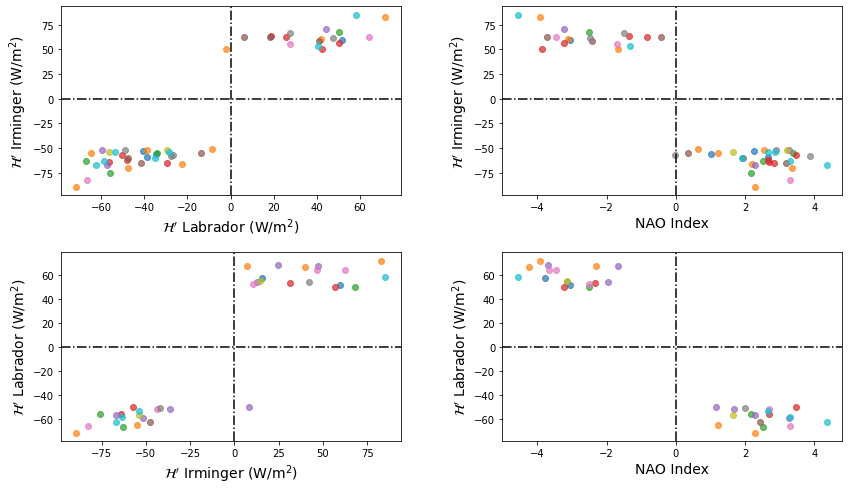

In [51]:
HF_cut = 50.

grid1 = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[14,8])

tmp1 = HF_Irm.isel(time=ind).where((HF_Irm.isel(time=ind).drop('time') >= HF_cut) | (HF_Irm.isel(time=ind).drop('time') <= -HF_cut))
for j in range(0,2):
    
    if(j==0):
        tmp2 = HF_Lab.isel(time=ind).where((HF_Irm.isel(time=ind).drop('time') >= HF_cut) | (HF_Irm.isel(time=ind).drop('time') <= -HF_cut))
    elif(j==1):
        tmp2 = NAO_season.isel(time=ind).where((HF_Irm.isel(time=ind).drop('time') >= HF_cut) | (HF_Irm.isel(time=ind).drop('time') <= -HF_cut))
    
    ax = fig.add_subplot(grid1[0, j])
    for r in range(0,10):

        ax.scatter(tmp2.isel(r=r), tmp1.isel(r=r), alpha=0.7)
    ax.axhline(y=0.0, color="k", linestyle="-.") 
    ax.axvline(x=0.0, color="k", linestyle="-.") 
    ax.set_ylabel(r'$\mathcal{H}^{\prime}$ Irminger (W/m$^2$)', fontsize=14)
    if(j==0):
        ax.set_xlabel(r'$\mathcal{H}^{\prime}$ Labrador (W/m$^2$)', fontsize=14)
    else:
        ax.set_xlabel('NAO Index', fontsize=14)
        
tmp1 = HF_Lab.isel(time=ind).where((HF_Lab.isel(time=ind).drop('time') >= HF_cut) | (HF_Lab.isel(time=ind).drop('time') <= -HF_cut))
for j in range(0,2):
    
    if(j==0):
        tmp2 = HF_Irm.isel(time=ind).where((HF_Lab.isel(time=ind).drop('time') >= HF_cut) | (HF_Lab.isel(time=ind).drop('time') <= -HF_cut))
    elif(j==1):
        tmp2 = NAO_season.isel(time=ind).where((HF_Lab.isel(time=ind).drop('time') >= HF_cut) | (HF_Lab.isel(time=ind).drop('time') <= -HF_cut))
    
    ax = fig.add_subplot(grid1[1, j])
    for r in range(0,10):

        ax.scatter(tmp2.isel(r=r), tmp1.isel(r=r), alpha=0.7)
    ax.axhline(y=0.0, color="k", linestyle="-.") 
    ax.axvline(x=0.0, color="k", linestyle="-.") 
    ax.set_ylabel(r'$\mathcal{H}^{\prime}$ Labrador (W/m$^2$)', fontsize=14)
    if(j==0):
        ax.set_xlabel(r'$\mathcal{H}^{\prime}$ Irminger (W/m$^2$)', fontsize=14)
    else:
        ax.set_xlabel('NAO Index', fontsize=14)